In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools as stat
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox as ljb
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')

# Raw data overview

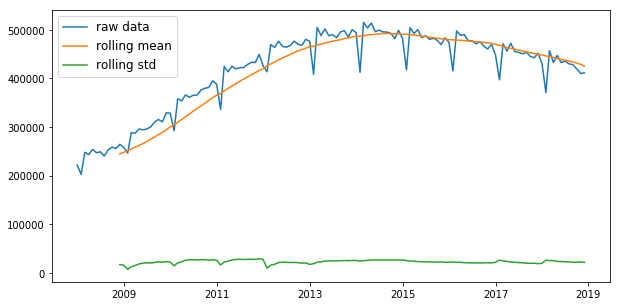

In [3]:
data = pd.read_excel(r'Call Time.xls', index_col = 'Date', names=['Time'])
romean = data.rolling(window=12,center=False).mean().dropna()
rostd = data.rolling(window=12,center=False).std().dropna()
plt.figure(figsize=(10,5))
plt.plot(data, label='raw data')
plt.plot(romean, label='rolling mean')
plt.plot(rostd, label='rolling std')
plt.legend(loc='upper left', fontsize='large')
plt.show()

In [4]:
# ADF test
stat.adfuller(data['Time'].values)

(-2.3931283306324858,
 0.14368528709248352,
 13,
 118,
 {'1%': -3.4870216863700767,
  '10%': -2.580009026141913,
  '5%': -2.8863625166643136},
 2489.667104534397)

p-Value is 0.14, higher than 0.05. The series is not stationary.

# Make series stationary using differentiality

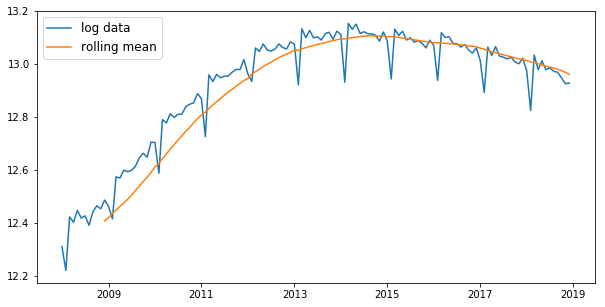

(-2.1163919413679646,
 0.2379746070888441,
 13,
 118,
 {'1%': -3.4870216863700767,
  '10%': -2.580009026141913,
  '5%': -2.8863625166643136},
 -560.1948567911243)

In [5]:
# Log data and check stationarity
logdata = np.log(data)
romean = logdata.rolling(window=12,center=False).mean().dropna()
#rostd = logdata.rolling(window=12,center=False).std().dropna()
plt.figure(figsize=(10,5))
plt.plot(logdata, label='log data')
plt.plot(romean, label='rolling mean')
#plt.plot(rostd, label='rolling std')
plt.legend(loc='upper left',fontsize='large')
plt.show()
stat.adfuller(logdata['Time'].values)

p-Value is 0.23. Not stationary.

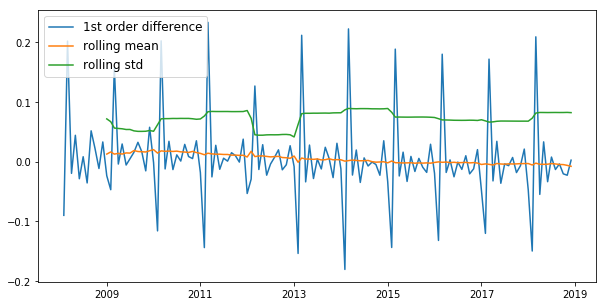

(-0.1966559587682468,
 0.9389190461446788,
 13,
 117,
 {'1%': -3.487517288664615,
  '10%': -2.5801239192052012,
  '5%': -2.8865777180380032},
 -561.030135773095)

In [6]:
# Check first order difference 
datadiff = logdata.diff().dropna()
romean = datadiff.rolling(window=12,center=False).mean().dropna()
rostd = datadiff.rolling(window=12,center=False).std().dropna()
plt.figure(figsize=(10,5))
plt.plot(datadiff, label='1st order difference')
plt.plot(romean, label='rolling mean')
plt.plot(rostd, label='rolling std')
plt.legend(loc='upper left',fontsize='large')
plt.show()
stat.adfuller(datadiff['Time'].values)

The figure of diffdata looks like it is stationary. However, adfuller test tells us it is not. It may because the trend is more like quadratic.

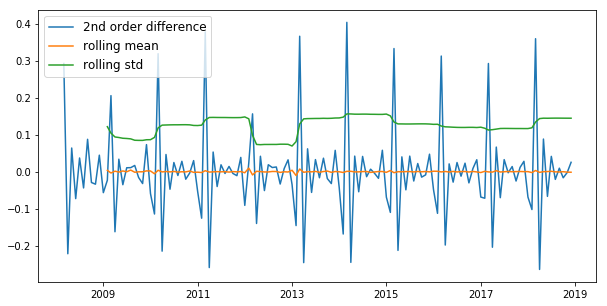

(-9.148263899987382,
 2.730376747876206e-15,
 13,
 116,
 {'1%': -3.4880216384691867,
  '10%': -2.5802408234244947,
  '5%': -2.8867966864160075},
 -559.6616688867182)

In [7]:
# Let's check 2nd order difference
datadiff2 = datadiff.diff().dropna()
romean = datadiff2.rolling(window=12,center=False).mean().dropna()
rostd = datadiff2.rolling(window=12,center=False).std().dropna()
plt.figure(figsize=(10,5))
plt.plot(datadiff2, label='2nd order difference')
plt.plot(romean, label='rolling mean')
plt.plot(rostd, label='rolling std')
plt.legend(loc='upper left',fontsize='large')
plt.show()
stat.adfuller(datadiff2['Time'].values)

Now we have a stationary series.

# Try ro remove trend and seasonarity

In [8]:
def f(x, A, B, C):
    return A*x**2 + B*x + C

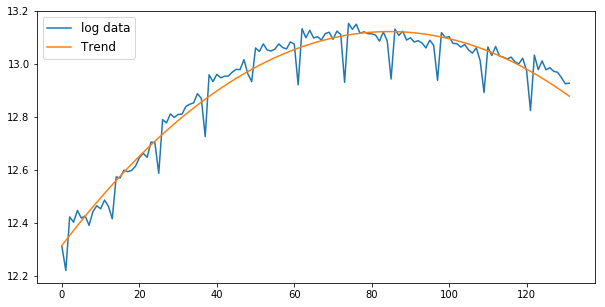

In [9]:
# Fit a quadratic trend
X = np.array(range(len(logdata.index)))
Y = logdata['Time'].values
[A,B,C] = optimize.curve_fit(f,X,Y)[0]
trend = A*np.power(X,2) + B*X + C
plt.figure(figsize=(10,5))
plt.plot(logdata['Time'].values, label = 'log data')
plt.plot(trend, label='Trend')
plt.legend(loc='upper left', fontsize='large')
plt.show()

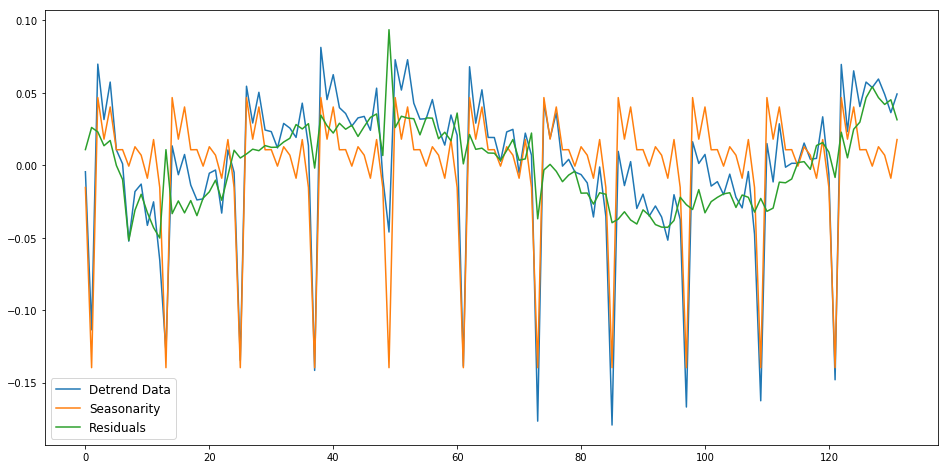

In [10]:
# Model seasonarity
detrend_data = logdata['Time'].values - trend
seasonarity = [0]*12
for i in range(len(detrend_data)):
    seasonarity[i%12] =  (detrend_data[i] + seasonarity[i%12] * (i//12)) / (i//12 + 1)
seasonarity = seasonarity - np.mean(seasonarity)
residual = detrend_data - np.tile(seasonarity, len(detrend_data)//12)
plt.figure(figsize= (16,8))
plt.plot(detrend_data, label='Detrend Data')
plt.plot(np.tile(seasonarity, len(detrend_data)//12), label='Seasonarity')
plt.plot(residual, label='Residuals')
plt.legend(loc='lower left', fontsize='large')
plt.show()

In [11]:
stat.adfuller(residual)

(-1.541113477402631,
 0.5130840044739168,
 4,
 127,
 {'1%': -3.482920063655088,
  '10%': -2.5790575441750883,
  '5%': -2.884580323367261},
 -691.4124504429478)

# Fit ARMA model

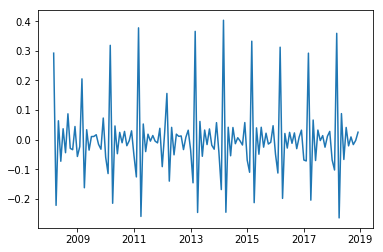

In [14]:
# Refresh data series we are going to model and split train and test
plt.plot(datadiff2)
plt.show()
# Train test split
data_test = datadiff2[-12:] # 2018 year
data_train = datadiff2[:-12] # 2008-2017 years

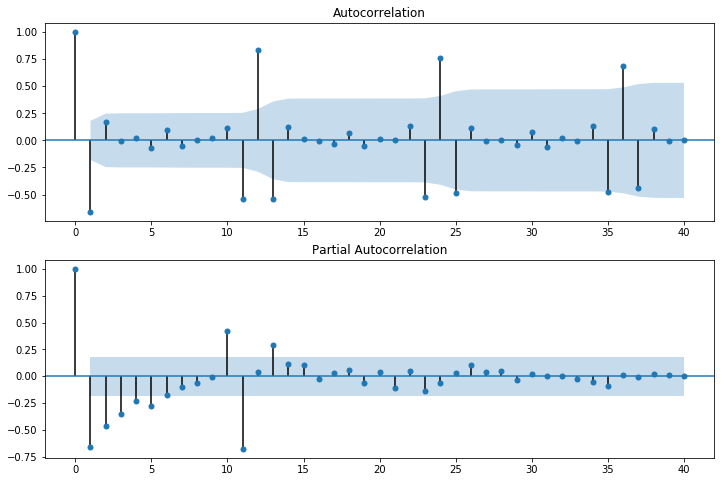

In [15]:
#ARMA model selection
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_train,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_train,lags=40,ax=ax2)

For ACF, we have a cut off after ACF(1) and it is out of confidence level. Also, ACF(11), ACF(12), ACF(13) are also out of confidence level. However, there are such long lags for ACF(11), ACF(12), ACF(13) so maybe it could be ignored.

For PACF, it decreases gradually, suggesting a feature of AR(0) may be observed. Considering, PACF(1), PACF(2), PACF(3), PACF(4), PACF(5) are out of confidence level, we can also use AR(1) - AR(5).

Combining them, I suggest we can select orders p of ARMA(p,q) model from [0, 1, 2, 3, 4, 5] and q of model from [1, 11, 12, 13].

In [17]:
#plt.show()
Display = pd.DataFrame(columns=['Orders', 'AIC', 'BIC', 'HQIC'])
for p in range(6):
    for q in [1, 11, 12, 13]:
        try:
            model = ARMA(data_train['Time'].values,order=(p,q)).fit()
        except:
            continue
            
        Display.loc[len(Display)+1] = {'Orders': (p,q), 'AIC': model.aic, 'BIC': model.bic, 'HQIC': model.hqic}
print(Display)

    Orders         AIC         BIC        HQIC
1   (0, 1) -284.472463 -276.160410 -281.097525
2   (1, 1) -316.895824 -305.813086 -312.395906
3   (2, 1) -327.126342 -313.272919 -321.501444
4   (3, 1) -331.346716 -314.722609 -324.596838
5  (3, 11) -360.272217 -315.941263 -342.272542
6   (4, 1) -334.400942 -315.006149 -326.526084
7  (4, 11) -382.299822 -335.198184 -363.175169
8   (5, 1) -339.326526 -317.161049 -330.326689


ARMA(4,11) is the best choice.

In [19]:
Model = ARMA(data_train['Time'].values,order=(4,11)).fit()
print(Model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  118
Model:                    ARMA(4, 11)   Log Likelihood                 208.150
Method:                       css-mle   S.D. of innovations              0.037
Date:                Thu, 09 May 2019   AIC                           -382.300
Time:                        18:26:06   BIC                           -335.198
Sample:                             0   HQIC                          -363.175
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002   2.19e-05    -11.277      0.000      -0.000      -0.000
ar.L1.y       -0.8107      0.157     -5.161      0.000      -1.119      -0.503
ar.L2.y       -1.0710      0.169     -6.342      0.0

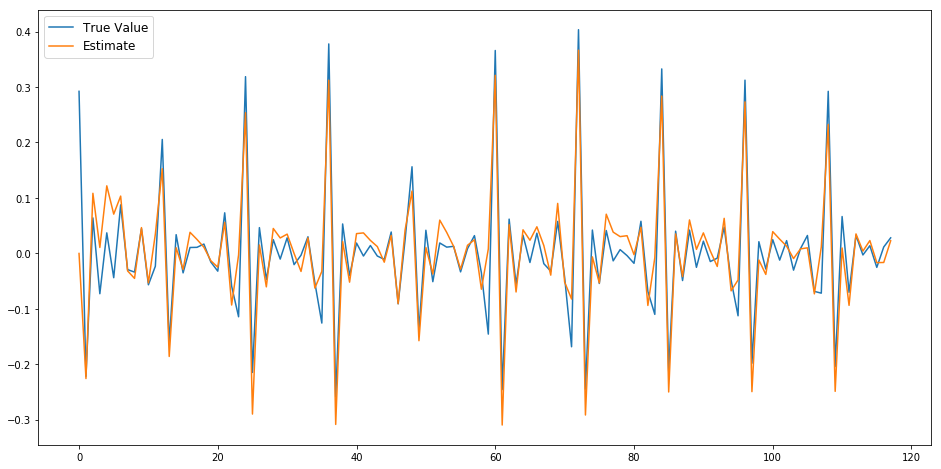

In [27]:
Estimate = Model.predict()
plt.figure(figsize=(16,8))
plt.plot(data_train['Time'].values, label='True Value')
plt.plot(Estimate, label='Estimate')
plt.legend(loc='upper left',fontsize='large')
plt.show()

In [34]:
# Check if residuals are white noises
residuals = Estimate - data_train['Time'].values
ljb(residuals)

(array([  0.31099413,   0.78413221,   4.34111394,   6.94194139,
         10.54541708,  12.00588262,  12.02455134,  12.02465391,
         15.53651996,  15.88078573,  16.60940092,  46.77388159,
         46.89348968,  46.8990626 ,  49.01167654,  49.8319856 ,
         50.25481901,  52.78514958,  53.06579187,  53.38166856,
         55.41416354,  56.33944587,  60.90087592,  92.7922077 ,
         93.66486367,  93.77883784,  94.88572356,  95.34248334,
         96.29241146,  97.2846557 ,  97.68692179,  97.73837701,
        101.48414846, 102.35564802, 106.01481144, 135.47076359,
        136.21104113, 136.28856607, 137.04686762, 137.77774583]),
 array([5.77070788e-01, 6.75659449e-01, 2.26907996e-01, 1.38988352e-01,
        6.11763156e-02, 6.18376989e-02, 9.97543696e-02, 1.50107271e-01,
        7.72141143e-02, 1.03096279e-01, 1.19972051e-01, 5.10120540e-06,
        1.00704227e-05, 1.99702147e-05, 1.74438247e-05, 2.43812629e-05,
        3.85593496e-05, 2.83216914e-05, 4.57511980e-05, 7.14053447e-05

Ljung Box test gives us p Value of each correlation. H0 hypothesis is correlation is 0. We can see except for the 1st and 2nd correlation, all p Value is less than 5%, while the 1st and 2nd are very close to 5%. At least, in 10% significance level, we can say we can not reject hypothesis that all correlations are 0. In conclusion, roughly speakly, our residuals are white noises.

# Forecast

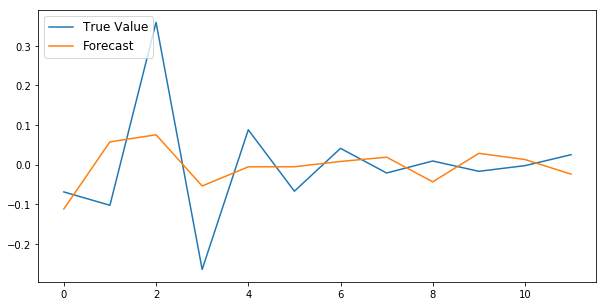

In [21]:
forecast,stderr,cfitvl = Model.forecast(steps=len(data_test))
plt.figure(figsize=(10,5))
plt.plot(data_test['Time'].values, label='True Value')
plt.plot(forecast, label='Forecast')
plt.legend(loc='upper left',fontsize='large')
plt.show()